In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mplfinance.original_flavor import candlestick2_ochl
from matplotlib import gridspec
import talib as TA
import warnings
import operator
import os
import math
import statistics

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',5000)

In [3]:
def calculateEMA(df,time_period):
    EMA=[]
    for time in time_period:
        EMA.append(TA.EMA(df['Close'],timeperiod=time))
    return EMA

In [4]:
def calculate_indicators(stock):

    os.chdir('/home/ronith/Documents/Career/PersonalProjects/TradingAlgorithmsAnalysis/Nifty50stocks/')
    filename=stock+'.NS.csv'
    stock=pd.read_csv(filename)
    
    if stock.isnull().values.any().any():
        #print('Dropping NaN from the data {}'.format(filename))
        stock=stock.dropna()
    
    #calculating EMA
    ema_9,ema_14,ema_20= calculateEMA(stock,[9,14,20])    
    stock['EMA_9']=ema_9
    stock['EMA_14']=ema_14
    stock['EMA_20']=ema_20  
    
    #calculating Stochastic RSI
    fastK, fastD = TA.STOCHRSI(stock['Close'], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=8)
    stock['StochRSI_fastK']=fastK
    stock['StochRSI_fastD']=fastD
    
    #calculating MACD
    macd, macd_signal, macd_hist = TA.MACD(stock['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    stock['MACD']=macd
    stock['MACD_Signal']=macd_signal
    stock['MACD_Histogram']=macd_hist   
    #display(ema_9,ema_14,ema_20,fastK,fastD,macd,macd_signal,macd_hist)
    #display(macd,macd_signal,macd_hist)
    
    #calculating ATR
    ATR = TA.ATR(stock['High'],stock['Low'],stock['Close'], timeperiod=14)
    stock['ATR']=ATR
    
    
    return stock

In [5]:
RELIANCE=calculate_indicators('RELIANCE')

# Candlestick-Charts

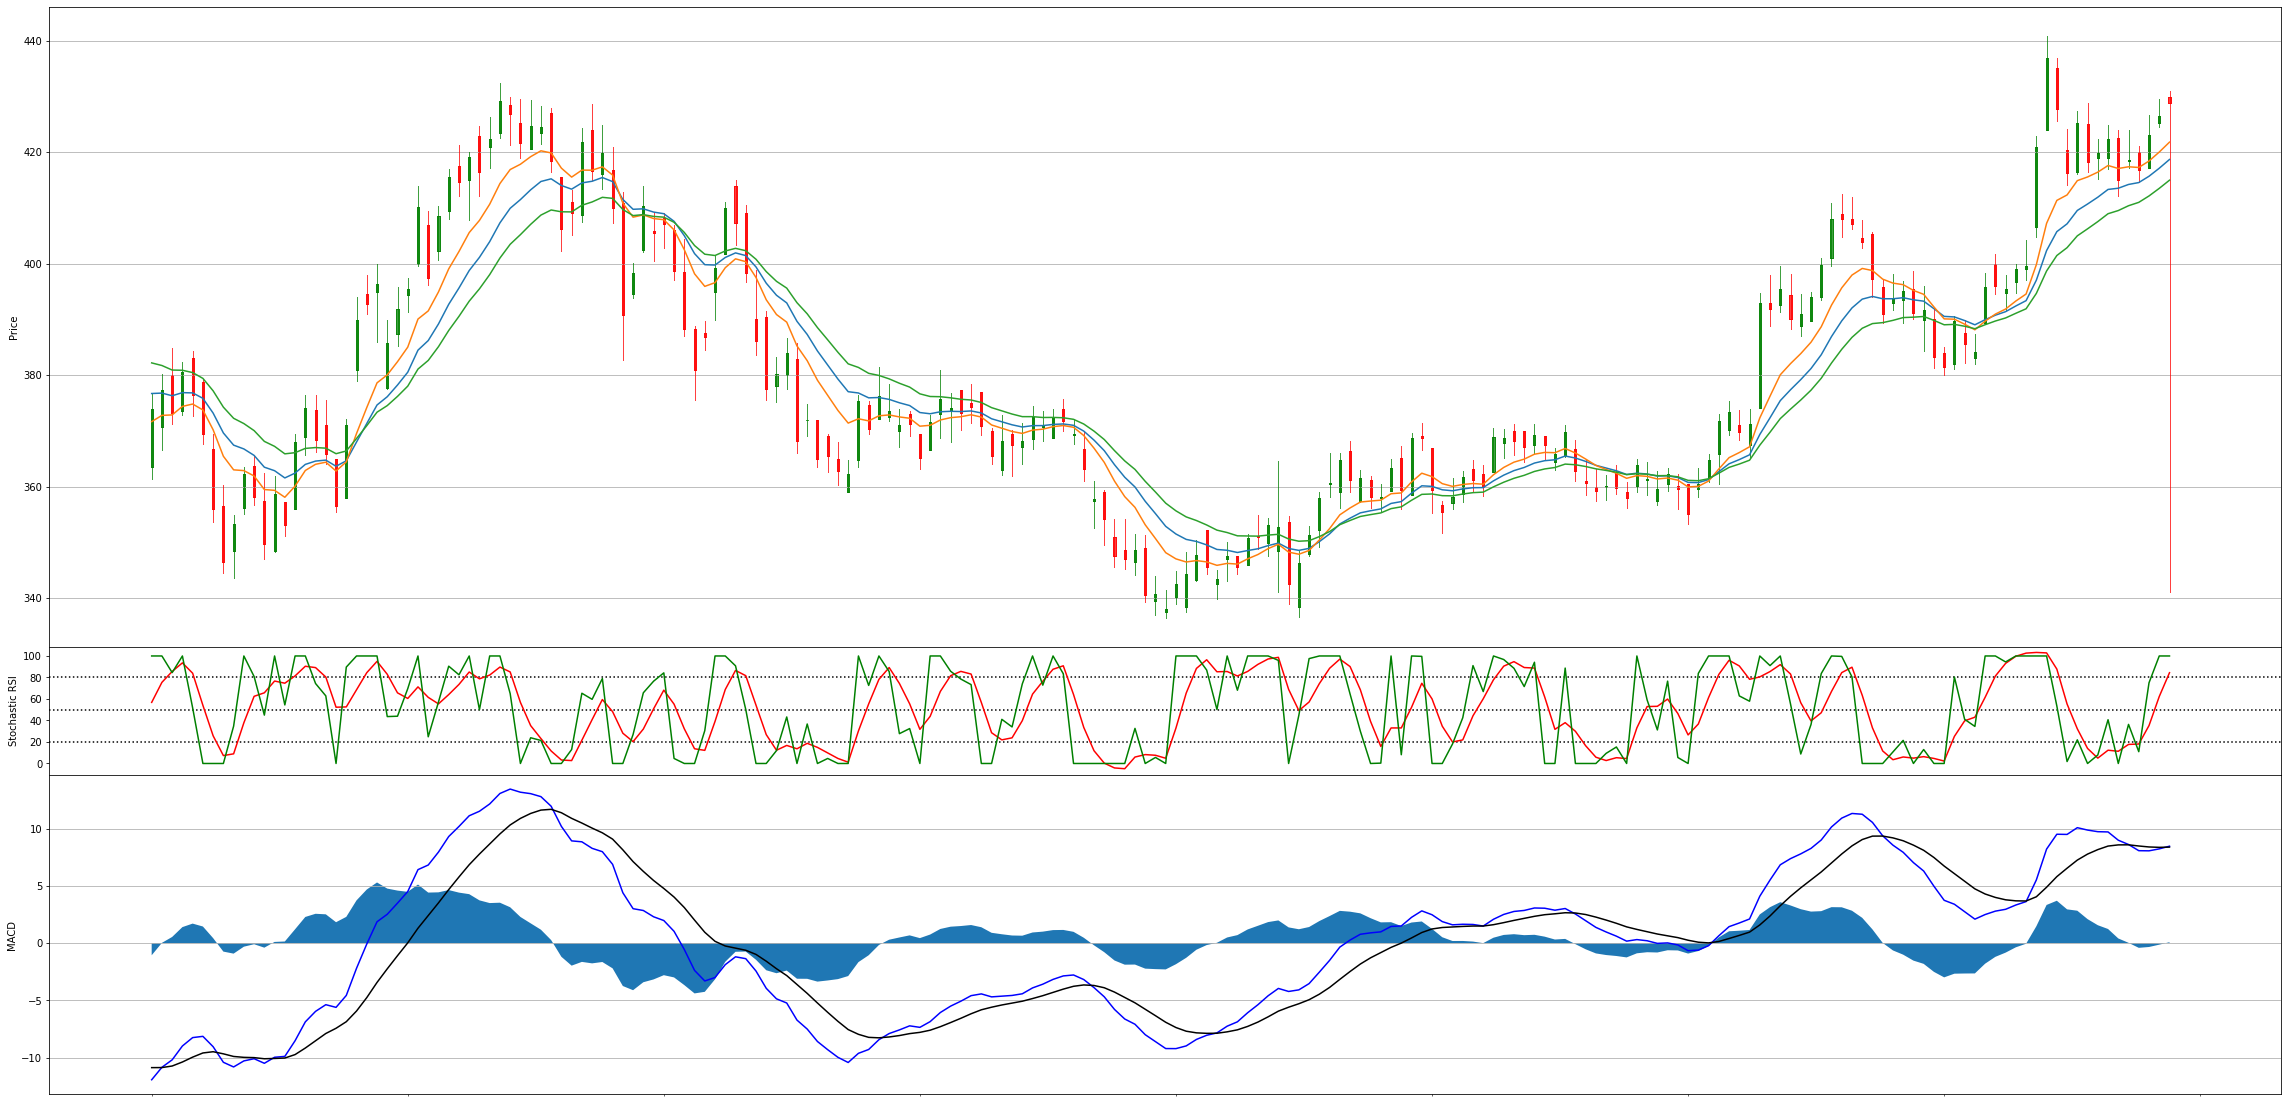

In [6]:
def plot_candlesticks(stock):
    fig=plt.figure(figsize=(40,20))
    gs = gridspec.GridSpec(3, 1, height_ratios=[10,2,5]) 

    candles_ax=plt.subplot(gs[0])
    candlestick2_ochl(candles_ax,stock['Open'],stock['Close'],stock['High'],stock['Low'],width=0.2,colorup='g',colordown='r')
    stock['EMA_14'].plot()
    stock['EMA_9'].plot()
    stock['EMA_20'].plot()
    candles_ax.grid(True)
    candles_ax.autoscale_view()
    candles_ax.set_ylabel('Price')
    candles_ax.plot()
    
    
    StochRSI_ax=plt.subplot(gs[1],sharex=candles_ax)
    StochRSI_ax.axhline(y=50,color='black',linestyle='dotted')
    StochRSI_ax.axhline(y=20,color='black',linestyle='dotted')
    StochRSI_ax.axhline(y=80,color='black',linestyle='dotted')
    stock['StochRSI_fastD'].plot(color='r')
    stock['StochRSI_fastK'].plot(color='g')
    StochRSI_ax.set_ylabel('Stochastic RSI')
    StochRSI_ax.plot()
    
    
    fill_color='b'
    MACD_ax = plt.subplot(gs[2],sharex=candles_ax)
    macd = MACD_ax.plot(stock.MACD, color='blue')
    macd = MACD_ax.plot(stock.MACD_Signal, color='black')
    macd = MACD_ax.fill_between(x=np.arange(stock.shape[0]),y1=stock.MACD_Histogram,y2=0)
    MACD_ax.set_ylabel('MACD')
    MACD_ax.grid(True)
    MACD_ax.plot()
        
    plt.subplots_adjust(hspace=.0)
    plt.xticks([])
    plt.show()
plot_candlesticks(RELIANCE.loc[300:500].reset_index().drop(['index'],axis=1))

# Generating Buy and Sell Signals

In [7]:
def condition_to_buy(current,previous,algorithm):
    close_price,EMA_9,EMA_14,EMA_20,Stoch_fastK,Stoch_fastD,MACD,MACD_Signal,MACD_Histogram,ATR,date= current
    previous_close_price,previous_EMA_9,previous_EMA_14,previous_EMA_20,previous_Stoch_fastK,previous_Stoch_fastD,previous_MACD,previous_MACD_Signal,previous_MACD_Histogram,ATR,previous_date=previous
    if algorithm not in ['MacdCrossover','StochRsiCrossover','EmaCrossover']:
        raise Exception("Algorithm should be either of ['MacdCrossover','StochRsiCrossover','EmaCrossover']")
    if algorithm=='MacdCrossover':
        if MACD>MACD_Signal and ATR/MACD>=3:
            return 1
    if algorithm=='StochRsiCrossover':
        if Stoch_fastK>Stoch_fastD:
            return 1
    if algorithm=='EmaCrossover':
        if Stoch_fastK>Stoch_fastD:
            return 1
    
    return 0

In [8]:
def condition_to_sell_if_bought(current,algorithm):
    close_price,EMA_9,EMA_14,EMA_20,Stoch_fastK,Stoch_fastD,MACD,MACD_Signal,MACD_Histogram,ATR,date= current
    if algorithm not in ['MacdCrossover','StochRsiCrossover','EmaCrossover']:
        raise Exception("Algorithm should be either of ['MacdCrossover','StochRsiCrossover','EmaCrossover']")
    
    if algorithm=='MacdCrossover':
        if MACD<MACD_Signal:
            return 1
    if algorithm=='EmaCrossover':
        if EMA_9<EMA_14:
            return 1
    if algorithm=='StochRsiCrossover':
        if Stoch_fastD>=Stoch_fastK:
            return 1
    return 0

In [16]:
def calculate_max_profit(data,algorithm):
    capital=50000
    current='hold'
    
    positive_trade=0
    negative_trade=0
    positive_trade_amount=0
    negative_trade_amount=0
    
    dates_list=[]
    action_list=[]
    investment_list=[]
    returns_list=[]
    profit_list=[]
    capital_list=[]
    stock_count_list=[]
    total_profit_list=[]
    
    cols_to_iterate=['Close','EMA_9','EMA_14','EMA_20','StochRSI_fastK','StochRSI_fastD','MACD','MACD_Signal','MACD_Histogram','ATR','Date']
    data_to_iterate=data[cols_to_iterate]
    
    buy_price,sell_price=0,0
    previous=data_to_iterate.loc[0]
    
    for row in data_to_iterate.iterrows():
        buy_stock=condition_to_buy(row[1],previous,algorithm)
        #sell_stock=condition_to_sell(row[1])
        dates_list.append(row[1][-1])
        
        if current=='buy':
            
            if condition_to_sell_if_bought(row[1],algorithm):
                sell_price=round(row[1][0],2)
                profit_per_stock=round(sell_price-buy_price,2)
                total_profit=round(profit_per_stock*stocks,2)
                capital=round(capital+total_profit,2)
                
                
                action_list.append('Sold')
                investment_list.append(buy_price)
                returns_list.append(sell_price)                  
                profit_list.append(profit_per_stock)
                stock_count_list.append(stocks)
                total_profit_list.append(total_profit)
                
                if profit_per_stock>=0:
                    positive_trade+=1
                    positive_trade_amount+=total_profit
                else:
                    negative_trade+=1
                    negative_trade_amount+=total_profit
                '''
                print('Date: ',row[1][-1],'-Sold at price: ',sell_price)
                print('Profit obtained= ',profit_per_stock)
                print('No. of stocks= ',stocks)
                print('Total profit= ',total_profit)
                print('Capital: ',capital)
                print('\n\n\n')
                '''
                current='hold'
                buy_price=0
                sell_price=0

            else:
                action_list.append('Hold')     
                investment_list.append(0)
                returns_list.append(0)                  
                profit_list.append(0)
                stock_count_list.append(0)
                total_profit_list.append(0)

        
        elif buy_stock:
            buy_price=round(row[1][0],2)
            stocks=math.floor(capital/buy_price)
            current='buy'        
            action_list.append('Bought')
            #print('Date: ',row[1][-1],'-Bought at price: ',buy_price)
            investment_list.append(0)
            returns_list.append(0)                  
            profit_list.append(0)
            stock_count_list.append(0)
            total_profit_list.append(0)


        else:
            action_list.append('No trade')
            investment_list.append(0)
            returns_list.append(0)                  
            profit_list.append(0)
            stock_count_list.append(0)
            total_profit_list.append(0)

        capital_list.append(capital)
        previous=row[1]
        
        '''
        if sell_stock and current!='sell':
            #print('Condition to sell: ')
            current='sell'
            action=True
            #display(row)
            #print('current= ', current)
    
        elif current=='sell' and condition_to_buy_if_sold(row[1]):
            #print('Condition to Buy if Sold: ')
            add_profit=previous-row[1][0]
            profit+=add_profit
            max_profit=max(profit,max_profit)
            max_profit_list.append(max_profit)

            #print('Add Profit,Max Profit ',add_profit,max_profit)
            profit=0
            max_profit=0

            current='hold'
            action=True
            #display(row)
            #print('current= ', current)

        elif current=='sell':
            #print('Hold Bought: ')
            #print('Add Profit,Max Profit ',add_profit,max_profit)
            add_profit=previous-row[1][0]
            profit+=add_profit
            max_profit=max(profit,max_profit)
        '''   
        
    return (dates_list,action_list,investment_list,returns_list,profit_list,stock_count_list,total_profit_list,capital_list,positive_trade,positive_trade_amount,negative_trade,negative_trade_amount)

In [17]:
def prepare_analysis_file(file,algorithm):
    location='/home/ronith/Documents/Career/PersonalProjects/TradingAlgorithmsAnalysis/Nifty50Analysis/'
    print(file[:-7],end=' ')
    try:
        data=pd.read_csv(file)
        data=calculate_indicators(file[:-7])
        dates_list,action_list,investment_list,returns_list,profit_list,stock_count_list,total_profit_list,capital_list,positive_trade,positive_trade_amount,negative_trade,negative_trade_amount=calculate_max_profit(data,algorithm)

        final_profit_data=pd.DataFrame(list(zip(dates_list,action_list,investment_list,returns_list,profit_list,stock_count_list,total_profit_list,capital_list)),columns=['Date','Action','Investment','Return','Profit','Stock Count','Total Profit','Capital'])        
        final_profit_data.to_csv(location+file)
        #display(final_profit_data)
        print('Successful') 
        print('Positive Trades: {}\nPositive Trade amount: {}\nNegative Trades: {}\nNegative Trade amount: {}\nAccuracy: {}'.format(positive_trade,positive_trade_amount,negative_trade,negative_trade_amount,positive_trade*100/(positive_trade+negative_trade)))
        return capital_list[-1]

    except Exception as e:
        print("Unsuccessful")
        print(e)
        return -1

In [18]:
def Nifty50_analysis_files(algorithm):
    result={}    
    os.chdir('/home/ronith/Documents/Career/PersonalProjects/TradingAlgorithmsAnalysis/Nifty50stocks/')
    Nifty50symbols=list(pd.read_csv('/home/ronith/Documents/Career/PersonalProjects/TradingAlgorithmsAnalysis/Nifty50stocks.csv')['Symbol'])
    for file in Nifty50symbols:
        result[file]=prepare_analysis_file(file+'.NS.csv',algorithm)
        #print(result[file[:-7]])
    return result

In [19]:
result=Nifty50_analysis_files('StochRsiCrossover')
result

EICHERMOT Successful
Positive Trades: 162
Positive Trade amount: 4270189.1
Negative Trades: 170
Negative Trade amount: -2172295.2499999995
Accuracy: 48.795180722891565
KOTAKBANK Successful
Positive Trades: 154
Positive Trade amount: 316808.10999999975
Negative Trades: 216
Negative Trade amount: -247014.06
Accuracy: 41.62162162162162
HCLTECH Successful
Positive Trades: 155
Positive Trade amount: 393742.9899999999
Negative Trades: 194
Negative Trade amount: -293152.06
Accuracy: 44.412607449856736
HINDUNILVR Successful
Positive Trades: 138
Positive Trade amount: 222606.29999999996
Negative Trades: 235
Negative Trade amount: -199452.59999999998
Accuracy: 36.997319034852545
TCS Successful
Positive Trades: 152
Positive Trade amount: 360004.77
Negative Trades: 190
Negative Trade amount: -223883.6099999999
Accuracy: 44.44444444444444
BRITANNIA Successful
Positive Trades: 148
Positive Trade amount: 519125.7500000001
Negative Trades: 187
Negative Trade amount: -287201.4500000001
Accuracy: 44.179

{'EICHERMOT': 2147893.85,
 'KOTAKBANK': 119794.05,
 'HCLTECH': 150590.93,
 'HINDUNILVR': 73153.7,
 'TCS': 186121.16,
 'BRITANNIA': 281924.3,
 'BHARTIARTL': 33363.0,
 'ASIANPAINT': 149532.69,
 'BAJFINANCE': 792504.32,
 'ADANIPORTS': 129298.6,
 'UPL': 183308.2,
 'GAIL': 127021.63,
 'BAJAJFINSV': 393364.77,
 'M&M': 66190.29,
 'SBIN': 261046.4,
 'HEROMOTOCO': 140391.2,
 'INDUSINDBK': 130051.6,
 'JSWSTEEL': 172496.63,
 'ULTRACEMCO': 161518.9,
 'TITAN': 76972.43,
 'LT': 171537.72,
 'BPCL': 260940.63,
 'DRREDDY': 125908.65,
 'ITC': 98705.23,
 'HDFCBANK': 71352.85,
 'POWERGRID': 28544.35,
 'SUNPHARMA': 133176.53,
 'BAJAJ-AUTO': 61141.5,
 'NTPC': 49478.75,
 'ONGC': 51160.9,
 'MARUTI': 160018.35,
 'TATASTEEL': 92602.01,
 'INFY': 55030.79,
 'AXISBANK': 298071.46,
 'HDFC': 82824.7,
 'COALINDIA': 67120.1,
 'ICICIBANK': 154777.71,
 'TATAMOTORS': 267040.69,
 'GRASIM': 105063.91,
 'IOC': 102574.94,
 'TECHM': 187956.81,
 'CIPLA': 51822.05,
 'RELIANCE': 147341.03,
 'INFRATEL': 54809.0,
 'HINDALCO': 6519

In [15]:
result=Nifty50_analysis_files('MacdCrossover')
result

EICHERMOT Successful
Positive Trades: 20
Positive Trade amount: 163738.94999999998
Negative Trades: 19
Negative Trade amount: -74028.7
Accuracy: 51.282051282051285
KOTAKBANK Successful
Positive Trades: 21
Positive Trade amount: 77522.39999999998
Negative Trades: 25
Negative Trade amount: -33417.62
Accuracy: 45.65217391304348
HCLTECH Successful
Positive Trades: 18
Positive Trade amount: 50994.72
Negative Trades: 27
Negative Trade amount: -50939.669999999984
Accuracy: 40.0
HINDUNILVR Successful
Positive Trades: 17
Positive Trade amount: 39307.049999999996
Negative Trades: 14
Negative Trade amount: -20195.550000000003
Accuracy: 54.83870967741935
TCS Successful
Positive Trades: 19
Positive Trade amount: 64780.280000000006
Negative Trades: 22
Negative Trade amount: -41754.00000000001
Accuracy: 46.34146341463415
BRITANNIA Successful
Positive Trades: 11
Positive Trade amount: 43683.799999999996
Negative Trades: 17
Negative Trade amount: -26392.100000000002
Accuracy: 39.285714285714285
BHARTIA

{'EICHERMOT': 139710.25,
 'KOTAKBANK': 94104.78,
 'HCLTECH': 50055.05,
 'HINDUNILVR': 69111.5,
 'TCS': 73026.28,
 'BRITANNIA': 67291.7,
 'BHARTIARTL': 43502.6,
 'ASIANPAINT': 88473.44,
 'BAJFINANCE': 169543.85,
 'ADANIPORTS': 31025.05,
 'UPL': 83687.75,
 'GAIL': 34299.08,
 'BAJAJFINSV': 229039.76,
 'M&M': 43902.03,
 'SBIN': 44314.63,
 'HEROMOTOCO': 66703.25,
 'INDUSINDBK': 82662.9,
 'JSWSTEEL': 93882.45,
 'ULTRACEMCO': 86423.45,
 'TITAN': 82263.56,
 'LT': 64504.93,
 'BPCL': 87191.42,
 'DRREDDY': 50761.05,
 'ITC': 56132.37,
 'HDFCBANK': 63348.34,
 'POWERGRID': 59729.4,
 'SUNPHARMA': 67588.22,
 'BAJAJ-AUTO': 39749.7,
 'NTPC': 61723.45,
 'ONGC': 26396.66,
 'MARUTI': 72895.55,
 'TATASTEEL': 62615.37,
 'INFY': 48334.75,
 'AXISBANK': 51450.18,
 'HDFC': 29560.95,
 'COALINDIA': 27297.7,
 'ICICIBANK': 76391.77,
 'TATAMOTORS': 84664.9,
 'GRASIM': 101551.96,
 'IOC': 56343.43,
 'TECHM': 76719.78,
 'CIPLA': 45137.25,
 'RELIANCE': 63294.71,
 'INFRATEL': 29796.3,
 'HINDALCO': 44517.0}

In [16]:
result=Nifty50_analysis_files('EmaCrossover')
result

EICHERMOT Successful
Positive Trades: 122
Positive Trade amount: 1852238.0
Negative Trades: 122
Negative Trade amount: -1060793.0499999998
Accuracy: 50.0
KOTAKBANK Successful
Positive Trades: 138
Positive Trade amount: 319460.25999999995
Negative Trades: 129
Negative Trade amount: -188469.12000000002
Accuracy: 51.68539325842696
HCLTECH Successful
Positive Trades: 151
Positive Trade amount: 285424.41000000003
Negative Trades: 131
Negative Trade amount: -221551.30000000002
Accuracy: 53.54609929078014
HINDUNILVR Successful
Positive Trades: 127
Positive Trade amount: 276578.39999999997
Negative Trades: 142
Negative Trade amount: -156605.45
Accuracy: 47.21189591078067
TCS Successful
Positive Trades: 156
Positive Trade amount: 140283.03000000003
Negative Trades: 135
Negative Trade amount: -115378.85000000008
Accuracy: 53.608247422680414
BRITANNIA Successful
Positive Trades: 123
Positive Trade amount: 840780.4
Negative Trades: 117
Negative Trade amount: -291558.10000000003
Accuracy: 51.25
BHA

{'EICHERMOT': 841444.95,
 'KOTAKBANK': 180991.14,
 'HCLTECH': 113873.11,
 'HINDUNILVR': 169972.95,
 'TCS': 74904.18,
 'BRITANNIA': 599222.3,
 'BHARTIARTL': 53163.05,
 'ASIANPAINT': 96731.63,
 'BAJFINANCE': 1049931.09,
 'ADANIPORTS': 41015.8,
 'UPL': 143776.65,
 'GAIL': 64443.78,
 'BAJAJFINSV': 600310.29,
 'M&M': 61443.62,
 'SBIN': 57007.24,
 'HEROMOTOCO': 64862.15,
 'INDUSINDBK': 269584.05,
 'JSWSTEEL': 157808.91,
 'ULTRACEMCO': 122887.15,
 'TITAN': 84021.95,
 'LT': 91347.58,
 'BPCL': 142918.16,
 'DRREDDY': 50489.7,
 'ITC': 61612.7,
 'HDFCBANK': 118847.75,
 'POWERGRID': 31330.85,
 'SUNPHARMA': 219051.98,
 'BAJAJ-AUTO': 36692.15,
 'NTPC': 47521.2,
 'ONGC': 29549.11,
 'MARUTI': 171731.0,
 'TATASTEEL': 76260.9,
 'INFY': 80046.7,
 'AXISBANK': 133014.3,
 'HDFC': 40147.7,
 'COALINDIA': 37812.25,
 'ICICIBANK': 84934.12,
 'TATAMOTORS': 85791.3,
 'GRASIM': 130817.54,
 'IOC': 72922.77,
 'TECHM': 176724.43,
 'CIPLA': 80237.35,
 'RELIANCE': 72953.06,
 'INFRATEL': 57116.4,
 'HINDALCO': 46620.3}

###  We start with a capital of Rs.50000 for each company and apply the Stochastic RSI algorithm for trading. 
### In the above cell, the variable 'result' contains the details of the final capital for each company. For example: The initial capital of Rs. 50,000 got converted to Rs. 1,29,298.6 for ADANIPORTS for the algorithm- StochRsiCrossover algorithm, and so on.

In [15]:
#The following function calculates the average and median profit for all Nifty50 stocks by assuming an initial capital of Rs.50,000.
def calculate_average_profit(algorithm):
    final_capital,stock_count=[0,0]
    capital_list=[]
    Nifty50symbols=pd.read_csv('/home/ronith/Documents/Career/PersonalProjects/TradingAlgorithmsAnalysis/Nifty50stocks.csv')['Symbol']
    for stock in Nifty50symbols:
        try:
            final_capital=prepare_analysis_file(stock+'.NS.csv',algorithm)
            capital_list.append(final_capital)
            print(final_capital)
            stock_count+=1
        except Exception as E:
            print(E)
    total_capital=sum(capital_list)
    print('\n\nTotal capital =',total_capital)
    print('Average capital =',total_capital/stock_count)
    print('Median capital =',statistics.median(capital_list))
    print('Calculating percentiles:')
    print('n=0\n',np.percentile(capital_list,0))
    print('n=5\n',np.percentile(capital_list,5))
    print('n=10\n',np.percentile(capital_list,10))
    print('n=25\n',np.percentile(capital_list,25))
    print('n=50\n',np.percentile(capital_list,50))
    print('n=75\n',np.percentile(capital_list,75))
    print('n=90\n',np.percentile(capital_list,90))    

In [20]:
calculate_average_profit('StochRsiCrossover') #Stochastic RSI

EICHERMOT Successful
Positive Trades: 162
Positive Trade amount: 4270189.1
Negative Trades: 170
Negative Trade amount: -2172295.2499999995
Accuracy: 48.795180722891565
2147893.85
KOTAKBANK Successful
Positive Trades: 154
Positive Trade amount: 316808.10999999975
Negative Trades: 216
Negative Trade amount: -247014.06
Accuracy: 41.62162162162162
119794.05
HCLTECH Successful
Positive Trades: 155
Positive Trade amount: 393742.9899999999
Negative Trades: 194
Negative Trade amount: -293152.06
Accuracy: 44.412607449856736
150590.93
HINDUNILVR Successful
Positive Trades: 138
Positive Trade amount: 222606.29999999996
Negative Trades: 235
Negative Trade amount: -199452.59999999998
Accuracy: 36.997319034852545
73153.7
TCS Successful
Positive Trades: 152
Positive Trade amount: 360004.77
Negative Trades: 190
Negative Trade amount: -223883.6099999999
Accuracy: 44.44444444444444
186121.16
BRITANNIA Successful
Positive Trades: 148
Positive Trade amount: 519125.7500000001
Negative Trades: 187
Negative 

In [21]:
calculate_average_profit('MacdCrossover') #MACD Crossover

EICHERMOT Successful
Positive Trades: 20
Positive Trade amount: 163738.94999999998
Negative Trades: 19
Negative Trade amount: -74028.7
Accuracy: 51.282051282051285
139710.25
KOTAKBANK Successful
Positive Trades: 21
Positive Trade amount: 77522.39999999998
Negative Trades: 25
Negative Trade amount: -33417.62
Accuracy: 45.65217391304348
94104.78
HCLTECH Successful
Positive Trades: 18
Positive Trade amount: 50994.72
Negative Trades: 27
Negative Trade amount: -50939.669999999984
Accuracy: 40.0
50055.05
HINDUNILVR Successful
Positive Trades: 17
Positive Trade amount: 39307.049999999996
Negative Trades: 14
Negative Trade amount: -20195.550000000003
Accuracy: 54.83870967741935
69111.5
TCS Successful
Positive Trades: 19
Positive Trade amount: 64780.280000000006
Negative Trades: 22
Negative Trade amount: -41754.00000000001
Accuracy: 46.34146341463415
73026.28
BRITANNIA Successful
Positive Trades: 11
Positive Trade amount: 43683.799999999996
Negative Trades: 17
Negative Trade amount: -26392.1000

In [22]:
calculate_average_profit('EmaCrossover') #EMA Crossover

EICHERMOT Successful
Positive Trades: 122
Positive Trade amount: 1852238.0
Negative Trades: 122
Negative Trade amount: -1060793.0499999998
Accuracy: 50.0
841444.95
KOTAKBANK Successful
Positive Trades: 138
Positive Trade amount: 319460.25999999995
Negative Trades: 129
Negative Trade amount: -188469.12000000002
Accuracy: 51.68539325842696
180991.14
HCLTECH Successful
Positive Trades: 151
Positive Trade amount: 285424.41000000003
Negative Trades: 131
Negative Trade amount: -221551.30000000002
Accuracy: 53.54609929078014
113873.11
HINDUNILVR Successful
Positive Trades: 127
Positive Trade amount: 276578.39999999997
Negative Trades: 142
Negative Trade amount: -156605.45
Accuracy: 47.21189591078067
169972.95
TCS Successful
Positive Trades: 156
Positive Trade amount: 140283.03000000003
Negative Trades: 135
Negative Trade amount: -115378.85000000008
Accuracy: 53.608247422680414
74904.18
BRITANNIA Successful
Positive Trades: 123
Positive Trade amount: 840780.4
Negative Trades: 117
Negative Trad

### I'm going to be choosing Stochastic RSI because of more average and median capital as compared to other algorithms like MACD Crossover, EMA Crossover.